## Spoznavanje z okoljem

In [ ]:
import pandas as pd
import cobra

from cobra.io import load_model

import numpy as np
import pickle

import os.path 

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import HTML

## *E. coli*

Preberimo model metabolizma *E. coli*. Model smo prenesli s strani http://bigg.ucsd.edu/models/e_coli_core.

In [2]:
model = cobra.io.read_sbml_model(os.path.join('models','e_coli_core.xml'))

In [6]:
model

Name,e_coli_core
Memory address,21f9e081d50
Number of metabolites,72
Number of reactions,95
Number of genes,137
Number of groups,0
Objective expression,1.0*BIOMASS_Ecoli_core_w_GAM - 1.0*BIOMASS_Ecoli_core_w_GAM_reverse_712e5
Compartments,"extracellular space, cytosol"


Nastavimo funkcijo biomase:

In [3]:
r_biomass = model.reactions.get_by_id('BIOMASS_Ecoli_core_w_GAM')
r_biomass

Reaction identifier,BIOMASS_Ecoli_core_w_GAM
Name,Biomass Objective Function with GAM
Memory address,0x21f9e8af3d0
Stoichiometry,1.496 3pg_c + 3.7478 accoa_c + 59.81 atp_c + 0.361 e4p_c + 0.0709 f6p_c + 0.129 g3p_c + 0.205 g6p_c + 0.2557 gln__L_c + 4.9414 glu__L_c + 59.81 h2o_c + 3.547 nad_c + 13.0279 nadph_c + 1.7867 oaa_c... 1.496 3-Phospho-D-glycerate + 3.7478 Acetyl-CoA + 59.81 ATP C10H12N5O13P3 + 0.361 D-Erythrose 4-phosphate + 0.0709 D-Fructose 6-phosphate + 0.129 Glyceraldehyde 3-phosphate + 0.205 D-Glucose...
GPR,
Lower bound,0.0
Upper bound,1000.0


In [4]:
model.objective = r_biomass

In [5]:
model.objective.expression

1.0*BIOMASS_Ecoli_core_w_GAM - 1.0*BIOMASS_Ecoli_core_w_GAM_reverse_712e5

In [14]:
sol = model.optimize()

In [17]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,10,6,100.00%
nh4_e,EX_nh4_e,4.765,0,0.00%
o2_e,EX_o2_e,21.8,0,0.00%
pi_e,EX_pi_e,3.215,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-22.81,1,100.00%
h2o_e,EX_h2o_e,-29.18,0,0.00%
h_e,EX_h_e,-17.53,0,0.00%


Rast celice torej znaša 0.874 $h^{-1}$.

Rezultat optimizacije lahko primerjamo z orodjem [Escher-FBA](https://sbrg.github.io/escher-fba/#/app):

In [18]:
sol = model.optimize()
sol['EX_glc__D_e']

-10.0

### Medij gojenja

Poskusimo spremeniti lastnosti medija. Kot vidimo zgoraj, celica črpa veliko glukoze (pretok je 10 $mmol gDW^{-1} hr^{-1}$ (milimoli na gram suhe celične mase na uro - privzete enote v okolju COBRA)). Kakšen je maksimalen dovod glukoze? Ali celica črpa vse, kar ima na voljo?

In [10]:
r_ex_glc = model.reactions.get_by_id('EX_glc__D_e')
r_ex_glc

Reaction identifier,EX_glc__D_e
Name,D-Glucose exchange
Memory address,0x21f9f8d28d0
Stoichiometry,glc__D_e <=> D-Glucose <=>
GPR,
Lower bound,-10.0
Upper bound,1000.0


Pretok je negativen, ampak reakcija je obrnjena! V orodju COBRA so vse *exchange* (*uptake* in *secretion*) reakcije take oblike. Kot vidimo, celica črpa vso glukozo, ki je na voljo. Poskusimo to zmanjšati:

In [20]:
r_ex_glc.bounds

(-10.0, 1000.0)

In [21]:
r_ex_glc.bounds = (0, 1000.0)
model.optimize()

C:\Users\miham\.conda\envs\metabolic\Lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


<Solution infeasible at 0x20a72279010>

Ups. Tole je bilo preveč. 

In [22]:
r_ex_glc.bounds = (-1.0, 1000.0)

In [23]:
model.optimize()

,fluxes,reduced_costs
PFK,0.951871,0.000000e+00
PFL,0.000000,-1.593358e-02
PGI,0.990081,0.000000e+00
PGK,-1.871378,-1.912182e-18
PGL,0.000000,1.235990e-17
...,...,...
NADH16,6.505410,0.000000e+00
NADTRHD,0.296355,1.734723e-18
NH4t,0.263834,9.309144e-20
O2t,3.885015,0.000000e+00


Poskusimo analizo ponoviti v anaerobnih pogojih. Nastavili bomo *uptake* kisika:

In [8]:
r_ex_o2 = model.reactions.get_by_id('EX_o2_e')
r_ex_o2

Reaction identifier,EX_o2_e
Name,O2 exchange
Memory address,0x21f9f8e5250
Stoichiometry,o2_e <=> O2 O2 <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [11]:
r_ex_glc.bounds = (-10.0, 1000.0)
r_ex_o2.bounds = (0, 1000)

In [26]:
model.optimize()

,fluxes,reduced_costs
PFK,9.789459e+00,6.938894e-18
PFL,1.780467e+01,3.642919e-17
PGI,9.956609e+00,0.000000e+00
PGK,-1.943734e+01,-1.912182e-18
PGL,0.000000e+00,1.344411e-17
...,...,...
NADH16,0.000000e+00,-2.215206e-02
NADTRHD,0.000000e+00,-1.107603e-02
NH4t,1.154156e+00,0.000000e+00
O2t,7.680432e-15,0.000000e+00


Produkcija biomase se je zmanjšala, prav tako pa se je preusmerila pot generiranja energije. Celica tvori in izloča acetat (`ac`), format (`for`) in etanol (`etoh`). Prej je izločala vodo in ogljikov dioksid.

In [27]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,0.3782,1,0.63%
glc__D_e,EX_glc__D_e,10,6,99.37%
h2o_e,EX_h2o_e,7.116,0,0.00%
nh4_e,EX_nh4_e,1.154,0,0.00%
pi_e,EX_pi_e,0.7786,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
ac_e,EX_ac_e,-8.504,2,33.11%
etoh_e,EX_etoh_e,-8.279,2,32.23%
for_e,EX_for_e,-17.8,1,34.66%
h_e,EX_h_e,-30.55,0,0.00%


In [51]:
s.objective_value

1.8589163614915776

Lahko naredimo analizo produkcije biomase glede na razpoložljivost kisika in glukoze:

In [12]:
o2_max = 30
glc_max = 30

# ustvarimo urejen seznam razpon vrednosti kisika in glukoze, za katere želimo narediti analizo
o2_range = np.arange(0, o2_max+1)
glc_range = np.arange(0, glc_max+1)

# ustvarimo matriko z dvema vrsticama - 1. za kisik, 2. za glukozo
# v vsaki vrstici je toliko ničel kot je število vrednosti, za katere bomo naredili analizo
# ničle se bodo tekom računanja spreminjale v ustrezna števila glede na rezultate analize
B = np.zeros((len(o2_range),len(glc_range)))

# za vsak par vrednosti o2 in glc se bo v matriko vpisal rezultat optimizacije
for i,o2 in enumerate(o2_range):
    for j,glc in enumerate(glc_range):
        r_ex_o2.lower_bound = -o2 # nastavitev spodnje meje reakcij privzema kisika
        r_ex_glc.lower_bound = -glc # nastavitev spodnje meje reakcij prvizema glukoze
        s = model.optimize()
        B[i,j] = s.objective_value # vpis rezultata v matriko

C:\Users\miham\.conda\envs\metabolic\Lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\miham\.conda\envs\metabolic\Lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\miham\.conda\envs\metabolic\Lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\miham\.conda\envs\metabolic\Lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\miham\.conda\envs\metabolic\Lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\miham\.conda\envs\metabolic\Lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is

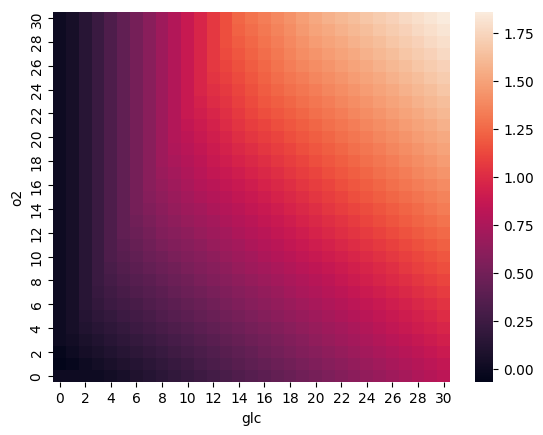

In [13]:
ax = sns.heatmap(B)
ax.invert_yaxis()
plt.xlabel("glc")
plt.ylabel("o2")
plt.show()

## FVA
FVA (Flux Variability Analysis) omogoča analizo razpona pretokov skozi rekacije pri (skoraj) optimalni produkciji biomase. 

In [15]:
from cobra.flux_analysis import flux_variability_analysis

In [16]:
fva = flux_variability_analysis(model, fraction_of_optimum=0.9, loopless=True)

In [17]:
fva

,minimum,maximum
PFK,17.834534,28.335842
PFL,0.000000,51.115905
PGI,0.771123,29.657030
PGK,-55.253294,-39.330957
PGL,0.000000,15.936583
...,...,...
NADH16,47.808710,71.793051
NADTRHD,0.000000,0.000000
NH4t,9.122669,14.843003
O2t,24.279667,30.000000


In [18]:
model.optimize()
model.summary(fva=0.90)

Metabolite,Reaction,Flux,Range,C-Number,C-Flux
glc__D_e,EX_glc__D_e,30,[27.14; 30],6,100.00%
nh4_e,EX_nh4_e,10.14,[9.629; 12.49],0,0.00%
o2_e,EX_o2_e,30,[27.14; 30],0,0.00%
pi_e,EX_pi_e,6.838,[6.496; 6.838],0,0.00%
Metabolite,Reaction,Flux,Range,C-Number,C-Flux
ac_e,EX_ac_e,-26.44,[-33.16; -4.88],2,52.40%
acald_e,EX_acald_e,0,[-11.44; 0],2,0.00%
akg_e,EX_akg_e,0,[-3.12; 0],5,0.00%
co2_e,EX_co2_e,-16.28,[-53.06; -10.15],1,16.13%
etoh_e,EX_etoh_e,0,[-21.02; 0],2,0.00%


### Geni v modelu

In [21]:
for r in model.reactions:
    print(r.gpr)

b3916 or b1723
((b0902 and b0903) and b2579) or (b0902 and b0903) or (b0902 and b3114) or (b3951 and b3952)
b4025
b2926
b0767
b0351 or b1241
b2587
b3612 or b4395 or b0755
b2987 or b3493
b0356 or b1478 or b1241
s0001
b3115 or b2296 or b1849
b3956
b0118 or b1276
b0118 or b1276

b3403

b1702
b0474
b0116 and b0726 and b0727
((b3736 and b3737 and b3738) and (b3731 and b3732 and b3733 and b3734 and b3735)) or ((b3736 and b3737 and b3738) and (b3731 and b3732 and b3733 and b3734 and b3735) and b3739)
b2297 or b2458
b1854 or b1676


s0001
b3386 or b4301
b0720
b2914 or b4090
b3528
(b0978 and b0979) or (b0733 and b0734)
b2975 or b3603
b2779


b0721 and b0722 and b0723 and b0724
b0728 and b0729
b2464 or b0008
b1602 and b1603
b2935 or b2465
b2935 or b2465
b3919




















b2097 or b1773 or b2925
b3925 or b4232
b0904 or b2492
b0904 or b2492
b4151 and b4152 and b4153 and b4154
b1817 and b1818 and b1819 and b2415 and b2416
b1612 or b4122 or b1611
b3528
b1852
b1779
(b2417 and b1101 and b2415 

In [31]:
model.genes.get_by_id('b4015')

Gene identifier,b4015
Name,aceA
Memory address,0x21f9e84c1d0
Functional,True
In 1 reaction(s),ICL


## Recon3D

Preberimo še model Recon3D. Predtem smo ga prenesli s strani [https://github.com/SBRG/Recon3D](https://github.com/SBRG/Recon3D). Opis modela je na voljo v [članku](http://dx.doi.org/10.1038/nbt.4072).

In [32]:
model = cobra.io.read_sbml_model(os.path.join('models','Recon3D.xml'))

In [37]:
model

Name,Recon3D
Memory address,21fa3440e90
Number of metabolites,5835
Number of reactions,10600
Number of genes,2248
Number of groups,0
Objective expression,1.0*BIOMASS_maintenance - 1.0*BIOMASS_maintenance_reverse_5b3f9
Compartments,"cytosol, lysosome, mitochondria, endoplasmic reticulum, extracellular space, peroxisome/glyoxysome, nucleus, golgi apparatus, inner mitochondrial compartment"


Poglejmo nekaj atributov modela:

In [33]:
model.genes[:3]

[<Gene 0 at 0x21fa326ffd0>,
 <Gene 26_AT1 at 0x21f9e78f6d0>,
 <Gene 314_AT1 at 0x21fa32afed0>]

In [34]:
model.metabolites[:3]

[<Metabolite 10fthf_c at 0x21fa2f4c150>,
 <Metabolite 10fthf_l at 0x21fa2f4ce90>,
 <Metabolite 10fthf_m at 0x21fa2e7bd10>]

In [35]:
model.reactions[:3]

[<Reaction 24_25DHVITD3tm at 0x21fcef56c10>,
 <Reaction 25HVITD3t at 0x21fcef568d0>,
 <Reaction COAtl at 0x21fcef57390>]

Povzetek modela lahko dobimo z metodo [summary](https://cobrapy.readthedocs.io/en/latest/autoapi/cobra/summary/model_summary/index.html):

In [36]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
thmtp_c,DM_thmtp_c,1000,12,4.09%
12ppd__R_e,EX_12ppd__R_e,250.8,3,0.26%
5aop_e,EX_5aop_e,1000,5,1.70%
HC00250_e,EX_HC00250_e,1000,0,0.00%
HC00900_e,EX_HC00900_e,1000,4,1.36%
HC01361_e,EX_HC01361_e,1000,9,3.07%
Lkynr_e,EX_Lkynr_e,105.1,10,0.36%
acetone_e,EX_acetone_e,427.7,3,0.44%
alltn_e,EX_alltn_e,1000,4,1.36%
atp_e,EX_atp_e,1000,10,3.41%


In [39]:
for r in model.reactions[:100]:
    gpr = r.gene_reaction_rule
    if gpr:
        print(gpr)

1591_AT1
8639_AT1 or 26_AT1 or 314_AT2 or 314_AT1
1594_AT1
10993_AT1
6818_AT1
89874_AT1
(4967_AT2 and 1738_AT1 and 8050_AT1 and 1743_AT1) or (4967_AT1 and 1738_AT1 and 8050_AT1 and 1743_AT1)
89874_AT1
117247_AT1
221_AT1 or 218_AT1 or 220_AT1
18_AT1 or 18_AT2
23498_AT1
4128_AT1 or 4129_AT1
4129_AT1 or 8639_AT1 or 26_AT1 or 314_AT2 or 314_AT1 or 4128_AT1
222_AT1 or 220_AT1 or 221_AT1 or 218_AT1
6799_AT1 or 6817_AT3 or 6799_AT2 or 6818_AT2 or 6817_AT2 or 6818_AT1 or 6817_AT1 or 6817_AT4 or 6818_AT3 or 6817_AT5
6822_AT1 or 6818_AT1
6573_AT1 or 6573_AT2
4128_AT1 or 4129_AT1
53947_AT1
53947_AT1
51146_AT1
28_AT1
28_AT1
28_AT1
28_AT1
28_AT1
28_AT1
18_AT1 or 18_AT2
206358_AT1
38_AT1 or 3032_AT1 or 10449_AT1
30_AT1
30_AT1
30_AT1
84532_AT1 or 79611_AT1
9197_AT1
6566_AT1 or 9123_AT1 or 9194_AT1
55577_AT1
5238_AT1
6572_AT1
26503_AT1
36_AT1 or 34_AT1
3712_AT1
34_AT1 or 27034_AT1
51_AT1 or 51_AT2
95_AT1
50_AT1 or 48_AT1
52_AT1 or 52_AT3 or 52_AT2 or 55_AT1 or 51205_AT1 or 54_AT1
55902_AT1 or 65985_AT

In [43]:
g = model.genes.get_by_id('55902_AT1')

Izpišimo gene, ki nastopajo v vsaj 5 reakcijah:

In [48]:
d = {}

for g in model.genes:
    d[g.name] = len(g.reactions)

In [64]:
sorted(list(d.items()), key=lambda x: x[1], reverse = True)

[('SLC7A6', 307),
 ('SLC15A1', 252),
 ('SLC15A2', 243),
 ('HADHA', 168),
 ('EHHADH', 166),
 ('SLCO1B1', 148),
 ('SLC27A2', 123),
 ('ACSL1', 122),
 ('ACAA1', 116),
 ('SLC7A5', 115),
 ('SLCO1A2', 106),
 ('HADHB', 105),
 ('CPT1A', 103),
 ('ACOX1', 100),
 ('ACADM', 98),
 ('HSD17B4', 98),
 ('ACSL5', 96),
 ('ACSBG2', 93),
 ('ACSL6', 93),
 ('CPT1C', 92),
 ('SLC25A20', 91),
 ('ABCA1', 90),
 ('SLC7A9', 86),
 ('ECHS1', 84),
 ('HADH', 81),
 ('ACADVL', 80),
 ('SLC16A1', 78),
 ('ACAA2', 77),
 ('ACSBG1', 76),
 ('BAAT', 73),
 ('CPT2', 68),
 ('CEL', 68),
 ('ABCC2', 62),
 ('ACOT2', 62),
 ('HEXA', 61),
 ('HEXB', 61),
 ('CYP3A4', 60),
 ('ACOT1', 60),
 ('LIPA', 60),
 ('ACOT7', 58),
 ('SOAT1', 57),
 ('ACOT6', 57),
 ('ACOT4', 56),
 ('SOAT2', 56),
 ('ABCB1', 56),
 ('SLC25A19', 55),
 ('LCAT', 55),
 ('HSD17B10', 54),
 ('SLC22A1', 54),
 ('ABCB11', 51),
 ('ACADL', 51),
 ('PLA2G4A', 50),
 ('PLA2G3', 50),
 ('PLA2G2A', 50),
 ('PLA2G12A', 50),
 ('PLA2G5', 50),
 ('PLA2G2F', 50),
 ('344967_AT1', 50),
 ('ACAD9', 49),
 